In [1]:
import os
import wandb
import logging
from pytorch_lightning.utilities.seed import seed_everything
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
from DLIP.utils.metrics.inst_seg_metrics import get_fast_aji_plus, remap_label


from DLIP.utils.loading.initialize_wandb import initialize_wandb
from DLIP.utils.loading.load_data_module import load_data_module
from DLIP.utils.loading.load_model import load_model
from DLIP.utils.loading.load_trainer import load_trainer
from DLIP.utils.loading.merge_configs import merge_configs
from DLIP.utils.loading.parse_arguments import parse_arguments
from DLIP.utils.loading.prepare_directory_structure import prepare_directory_structure
from DLIP.utils.loading.split_parameters import split_parameters
from DLIP.utils.cross_validation.cv_trainer import CVTrainer

/home/ws/kg2371/anaconda3/envs/sem-segmentation/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [24]:
MIN_MASK_SIZE_THESHOLD = 10

OVERLAPPING_THRESHOLD = 0.41
MIN_ACTIVATION = 0.53
# conf: lower_threshold = THRESHOLD_CONF, high_threshold = 1.0
THRESHOLD_CONF = 0.8
# not_conf: lower_threshold = THRESHOLD_NOT_CONF, high_threshold = THRESHOLD_CONF
THRESHOLD_NOT_CONF = 0.55

def post_process(pred,lower_threshold,high_threshold,H,W):
    scores = pred['scores']
    masks = pred['masks']   
    masks = masks[(scores > lower_threshold) & (scores <= high_threshold)]
    scores = scores[(scores > lower_threshold) & (scores <= high_threshold)]
    masks_summed = torch.zeros((H,W))
    if len(masks) == 0:
        return masks_summed
    final_mask = torch.stack(sorted(masks,key=lambda x: torch.sum(x>MIN_ACTIVATION)))
    for j in range(len(final_mask)):
        masks_summed[(final_mask[j]> MIN_ACTIVATION).squeeze()] = j+1
    return masks_summed.to(torch.uint8)

In [3]:
logging.basicConfig(level=logging.INFO)
logging.info("Initalizing model")

config_files = '/home/ws/kg2371/projects/sem-segmentation/DLIP/experiments/configurations/bmt_maskedrcnn.yaml'
result_dir = './'


cfg_yaml = merge_configs(config_files)
base_path=os.path.expandvars(result_dir)
experiment_name=cfg_yaml['experiment.name']['value']

cfg_yaml['wandb.mode']['value'] = 'disabled'

experiment_dir, config_name = prepare_directory_structure(
    base_path=base_path,
    experiment_name=experiment_name,
    data_module_name=cfg_yaml['data.datamodule.name']['value'],
    model_name=cfg_yaml['model.name']['value']
)

config = initialize_wandb(
    cfg_yaml=cfg_yaml,
    experiment_dir=experiment_dir,
    config_name=config_name
)

config.update({'data.datamodule.arguments.root_dir':f"{config['prefix']}/{config['root_dir_base']}"},allow_val_change=True) 


seed_everything(seed=cfg_yaml['experiment.seed']['value'])
parameters_splitted = split_parameters(config, ["model", "train", "data"])

model = load_model(parameters_splitted["model"],
                 checkpoint_path_str='/home/ws/kg2371/projects/sem-segmentation/results/first-shot/GenericSegmentationDataModule/MaskedRCNN/0136/dnn_weights.ckpt'
)

data = load_data_module(parameters_splitted["data"])
trainer = load_trainer(parameters_splitted['train'], experiment_dir, wandb.run.name, data)

INFO:root:Initalizing model
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Global seed set to 1337
INFO:root:Using 32 workers for data loading
INFO:root:Length of validation dataset: 26
INFO:root:Length of test dataset: 28
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [4]:
x = torch.zeros((0,1,512,512))
y_true = torch.zeros((0,256,512,512))
y_pred = []

model.eval()
for batch in tqdm(data.test_dataloader()):
    x_step, y_true_step   = batch
    x = torch.concat((x,x_step))
    y_true = torch.concat((y_true,y_true_step))
    y_pred_step = model(x_step,None)
    y_pred.extend(y_pred_step)

100%|██████████| 2/2 [00:20<00:00, 10.16s/it]


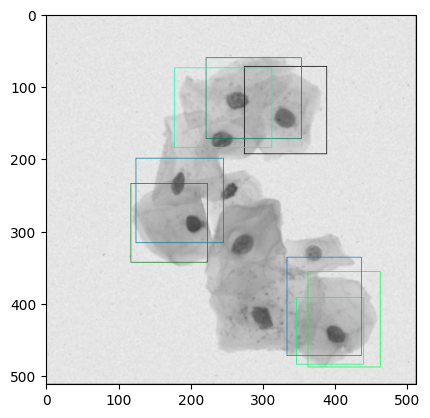

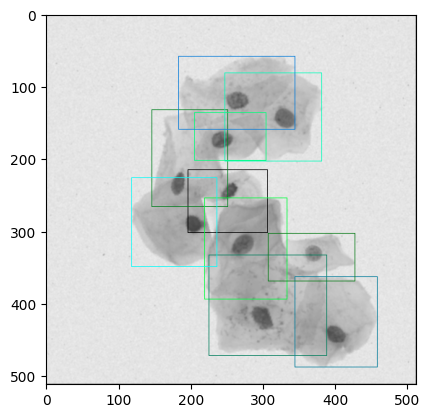

In [29]:
k = 0

# plt.imshow(x[k].permute(1,2,0),cmap='gray')
# plt.show()

# true_fileterd = torch.stack([y_true[k][i] for i in range(len(y_true[k])) if torch.sum(y_true[k][i])>0])
# plt.imshow(x[k].permute(1,2,0),cmap='gray')
# plt.imshow(true_fileterd.sum(0))
# plt.show()


# fileterd = y_pred[k]['masks'][y_pred[k]['scores']>THRESHOLD_CONF]
# plt.imshow(x[k].permute(1,2,0),cmap='gray')
# for mask in fileterd:
#     plt.imshow(mask.permute(1,2,0).detach().cpu().numpy()>MIN_ACTIVATION,alpha=0.5)
# plt.show()

k=15
boxes_filtered = y_pred[k]['boxes'][y_pred[k]['scores']>THRESHOLD_CONF]
plt.imshow(draw_bounding_boxes((x[k]*255).to(torch.uint8),boxes_filtered).permute(1,2,0))
plt.show()

true_fileterd = torch.stack([y_true[k][i] for i in range(len(y_true[k])) if torch.sum(y_true[k][i])>0])
boxes_true = masks_to_boxes(true_fileterd)
plt.imshow(draw_bounding_boxes((x[k]*255).to(torch.uint8),boxes_true).permute(1,2,0))
plt.show()


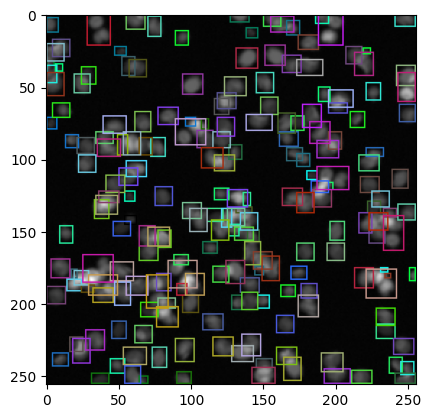

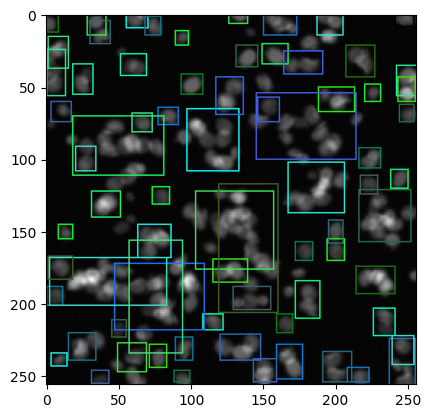

In [14]:
k=4
masks = torch.stack([(y_true[k]==i)*1 for i in range(1,int(torch.max(y_true[k])+1)) if torch.sum((y_true[k]==i)*1) > MIN_MASK_SIZE_THESHOLD])
boxes =  masks_to_boxes(masks[:,:,:,0])
plt.imshow(draw_bounding_boxes((x[k]*255).to(torch.uint8),boxes).permute(1,2,0))
plt.show()
plt.imshow(draw_bounding_boxes((x[k]*255).to(torch.uint8),y_pred[k]['boxes'][y_pred[k]['scores']>THRESHOLD_CONF]).permute(1,2,0))


In [8]:
post_process(y_pred[0],THRESHOLD_CONF,1.0,256,256)

torch.Size([256, 256])

In [57]:
H,W,C = y_pred[k]['masks'][0].shape
pred_masks_conf = post_process(y_pred[k],THRESHOLD_CONF,1.0,H,W)

RuntimeError: Output 0 of SqueezeBackward0 is a view and is being modified inplace. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.

In [59]:
y_pred[k]

AttributeError: 'dict' object has no attribute 'detach'